This code was adapted from Chris Holden (ceholden@gmail.com) Chaoter 5 Lesson on Ladncover Classification: https://ceholden.github.io/open-geo-tutorial/python/chapter_5_classification.html - https://github.com/ceholden



### Imports

In [6]:
# Import Python 3's print function and division
from __future__ import print_function, division

# Import GDAL, NumPy, and matplotlib
from osgeo import gdal, gdal_array
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

## Sklearn Libraries
from sklearn.utils import shuffle
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
from sklearn.metrics import f1_score, confusion_matrix, roc_curve, auc, \
            classification_report, recall_score, precision_recall_curve

# Define random state
random_state = 2018
np.random.seed(random_state)
warnings.filterwarnings('ignore')


# Tell GDAL to throw Python exceptions, and register all drivers
gdal.UseExceptions()
gdal.AllRegister()

### Preparing The Dataset

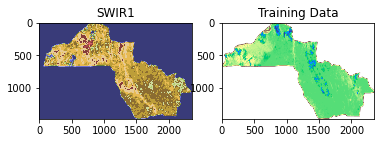

In [8]:
# Read in our satellite and label image
satellite_img = gdal.Open('/gws/nopw/j04/ai4er/users/jl2182/data/Mres_Data/classification_training_data/filled_l8_training_data.tif', gdal.GA_ReadOnly)
training_img = gdal.Open('/gws/nopw/j04/ai4er/users/jl2182/data/Mres_Data/classification_training_data/esa_landcover_training_data.tif', gdal.GA_ReadOnly)

img = np.zeros((satellite_img.RasterYSize, satellite_img.RasterXSize, satellite_img.RasterCount),
               gdal_array.GDALTypeCodeToNumericTypeCode(satellite_img.GetRasterBand(1).DataType))
for b in range(img.shape[2]):
    img[:, :, b] = satellite_img.GetRasterBand(b + 1).ReadAsArray()
    
lbls = training_img.GetRasterBand(1).ReadAsArray().astype(np.uint8)

# Display them
plt.subplot(121)
plt.imshow(img[:, :, 4], cmap=plt.cm.tab20b)
plt.title('SWIR1')

plt.subplot(122)
plt.imshow(lbls, cmap=plt.cm.terrain)
plt.title('Training Data')

plt.show()

In [3]:
#img.shape

In [14]:
#lbls.shape

Creating the X feature matrix array and the y labels matrix to be fed into the Random Forest

In [9]:
# Find how many non-zero entries we have -- i.e. how many training data samples?
n_samples = (lbls > 0).sum()
print('We have {n} samples'.format(n=n_samples))

# What are our classification labels?
labels = np.unique(lbls[lbls > 0])
print('The training data include {n} classes: {classes}'.format(n=labels.size, 
                                                                classes=labels))
# We will need a "X" matrix containing our features, and a "y" array containing our labels
#     These will have n_samples rows
#     In other languages we would need to allocate these and them loop to fill them, but NumPy can be faster

#this is a wuick numpy trick for flattening
X = img[lbls > 0, :]  # include 8th band, which is Fmask, for now
y = lbls[lbls > 0]

print('Our X matrix is sized: {sz}'.format(sz=X.shape))
print('Our y array is sized: {sz}'.format(sz=y.shape))



We have 3489499 samples
The training data include 10 classes: [ 1  2  3  4  5  6  7  8  9 10]
Our X matrix is sized: (3489499, 7)
Our y array is sized: (3489499,)


### Training The Random Forest

In [10]:
# Initialize our model with 500 trees
rf = RandomForestClassifier(n_estimators=500, oob_score=True)

# Fit our model to training data
rf = rf.fit(X, y)

### Accuracy

In [11]:
print('Our OOB prediction of accuracy is: {oob}%'.format(oob=rf.oob_score_ * 100))


Our OOB prediction of accuracy is: 91.8282251979439%


### Band Importance

In [12]:
bands = [1, 2, 3, 4, 5, 6,7,8,9,10]

for b, imp in zip(bands, rf.feature_importances_):
    print('Band {b} importance: {imp}'.format(b=b, imp=imp))

Band 1 importance: 0.03796131446919975
Band 2 importance: 0.16493721601466424
Band 3 importance: 0.15308132364361088
Band 4 importance: 0.15453980021614264
Band 5 importance: 0.15393285434656578
Band 6 importance: 0.16376191383374633
Band 7 importance: 0.17178557747607043


In [ ]:
#scientific comment on band importance

In [13]:
import pandas as pd

# Setup a dataframe -- just like R
df = pd.DataFrame()
df['truth'] = y
df['predict'] = rf.predict(X)

# Cross-tabulate predictions
print(pd.crosstab(df['truth'], df['predict'], margins=True))

predict      1      2     3       4       5      6     7     8  9       10  \
truth                                                                        
1        66022      0     0       0       0      0     0     0  0     4949   
2            0  17147     0       0       0      0     0     0  0     1789   
3            0      0  4156       0       0      0     0     0  0      160   
4            0      0     0  930592       0      0     0     0  0    12403   
5            0      0     0       0  208562      0     0     0  0    16777   
6            0      0     0       0       0  42769     0     0  0     6436   
7            0      0     0       0       0      0  3921     0  0      114   
8            0      0     0       0       0      0     0  4959  0     1840   
9            0      0     0       0       0      0     0     0  1        0   
10           0      0     0       0       0      0     0     0  0  2166902   
All      66022  17147  4156  930592  208562  42769  3921  4959  